# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("data/returns.csv")[1:]

# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']

rets.head()

USA_EWJ   USA_EWT  USA_MCHI   USA_EWY   USA_EWZ  USA_INDA  \
Date                                                                     
2011-01-04  0.000804 -0.007407       NaN  0.002263  0.004396       NaN   
2011-01-05 -0.007231 -0.016584       NaN  0.000376 -0.011616       NaN   
2011-01-06  0.000000 -0.002108       NaN -0.006960 -0.010049       NaN   
2011-01-07  0.003777 -0.015632       NaN  0.005493 -0.009119       NaN   
2011-01-10  0.000000  0.002146       NaN -0.014883 -0.010071       NaN   

            USA_ACWV   USA_IDV   USA_EWC   USA_EWU  ...  CAN_HULC.TO  \
Date                                                ...                
2011-01-04       NaN -0.009259 -0.010412  0.010462  ...          NaN   
2011-01-05       NaN -0.002596  0.002023 -0.002157  ...          NaN   
2011-01-06       NaN -0.009891 -0.004847 -0.008647  ...          NaN   
2011-01-07       NaN -0.005258  0.000406 -0.003925  ...          NaN   
2011-01-10       NaN  0.000529 -0.003651  0.001751  ...          NaN   

            CAN_HMUS.TO  CAN_HSUV.TO  USA_CNY=X  USA_BRL=X  USA_ZAR=X  \
Date                                                                    
2011-01-04          NaN          NaN  -0.001760   0.019189   0.006326   
2011-01-05          NaN          NaN   0.002584   0.012754   0.003853   
2011-01-06          NaN          NaN  -0.002956   0.004498   0.008670   
2011-01-07          NaN          NaN   0.005929   0.006507   0.012983   
2011-01-10          NaN          NaN   0.000151  -0.029895  -0.000295   

            USA_RUB=X  USA_EUR=X  USA_JPY=X  USA_MXN=X  
Date                                                    
2011-01-04        0.0   0.000134   0.006743  -0.000384  
2011-01-05        0.0   0.002671   0.004506  -0.004249  
2011-01-06        0.0   0.012522   0.014030   0.003119  
2011-01-07        0.0   0.013551   0.001334   0.000573  
2011-01-10        0.0   0.006620  -0.003241  -0.001063  

[5 rows x 128 columns]

In [3]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [4]:
sum(rets["USA_RUB=X"] > 100)

0

In [5]:
# read the risk free rate
riskfree = pd.read_csv("data/3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])

# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')

# daily risk free
riskfree = (1 + riskfree).pow(1/252) - 1

riskfree.head()

RFR
Date                
2011-01-04  0.000520
2011-01-05  0.000520
2011-01-06  0.000537
2011-01-07  0.000520
2011-01-10  0.000520

In [6]:
len(riskfree.index) == len(rets.index)

True

In [7]:
# benchmark index (MSCI ACWI Index)
benchmark = pd.read_csv("data/benchmark.csv")
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

# calculate returns
benchmark['return'] = benchmark['Adj_Close'].pct_change()

# match the date
benchmark = benchmark[benchmark['Date'].isin(rets.index.values)].set_index('Date')

# calculate excess returns
rf_bm = riskfree[riskfree.index.isin(benchmark.index.values)]
benchmark_ret = benchmark['return']
benchmark_excess = benchmark['return'].subtract(rf_bm['RFR'], axis=0)

In [8]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

In [9]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [10]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])
print(semiannual[1].index[0],semiannual[1].index[-1])
print(semiannual[19].index[0],semiannual[19].index[-1])

2011-01-31 00:00:00 2011-07-29 00:00:00
2011-08-01 00:00:00 2012-01-31 00:00:00
2020-07-31 00:00:00 2021-01-29 00:00:00


# Lowest correlation Search

In [11]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)

# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XFR.TO    0.075507
CAN_CMR.TO    0.081464
USA_JPY=X     0.082320
USA_RUB=X     0.084428
USA_BRL=X     0.085703
CAN_HXQ.TO    0.097759
CAN_HHF.TO    0.113232
CAN_CBO.TO    0.113303
USA_ZAR=X     0.118197
USA_CNY=X     0.120320
CAN_HUZ.TO    0.144101
USA_EUR=X     0.151444
CAN_XSC.TO    0.154957
CAN_SVR.TO    0.162192
CAN_HXF.TO    0.165272
CAN_XGD.TO    0.181217
CAN_HUN.TO    0.185430
CAN_XIG.TO    0.186638
CAN_CVD.TO    0.190808
USA_KSA       0.198407
CAN_CBH.TO    0.199100
CAN_HUG.TO    0.208522
CAN_HTB.TO    0.237717
CAN_XUU.TO    0.248717
CAN_CGL.TO    0.253634
CAN_CLF.TO    0.280254
CAN_CGR.TO    0.283629
CAN_CLG.TO    0.284980
CAN_HXE.TO    0.285884
USA_QAT       0.286492
dtype: float64

In [12]:
# Loop through each semiannual period, save the 10, 15 or 30 Canadian and USA assets with the
# lowest average correlation
top10 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top10[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top30[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:30]

# Portfolio weight optimization -- MVO, Risk Parity and Sharpe Ratio Maximization results Compare with Equally-weighted & Risk metrics, Cutoff calibration

In [13]:
# import modules 

import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer

from importlib import reload
reload(portfolio_optimizer)

from portfolio_optimizer import portfolio_optimizer

In [14]:
# Risk mapping Parameter
VaRcutoff = {'VaR95':1100,'VaR99':1800,'CVaR95':2700,'CVaR99':4400}

10 cutoff ETFs

In [15]:
opt10 = portfolio_optimizer(semiannual)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Equally weighted')

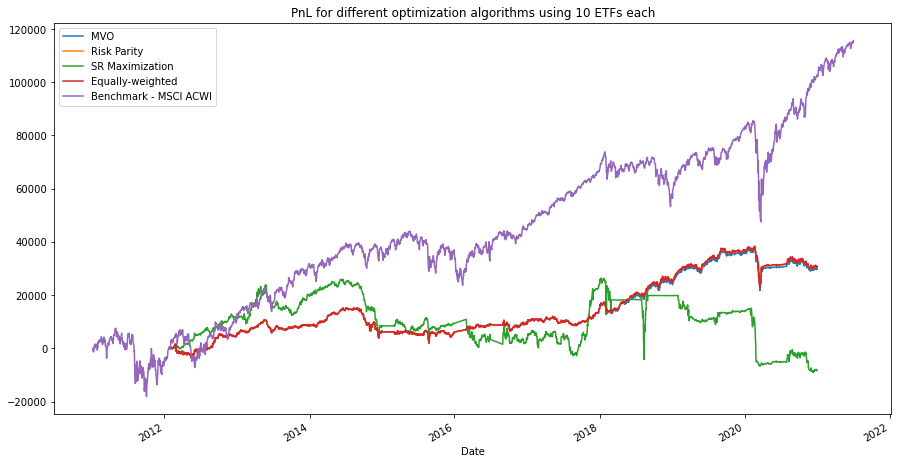

In [16]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
(benchmark_ret*100000).cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('PnL for different optimization algorithms using 10 ETFs each')
plt.legend()
plt.show()

In [17]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -320.70809869652754%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -777.597221 -1275.539843 -1077.272095 -1522.524440
3       -594.265835  -764.401526  -711.812274  -892.438969
4       -528.285262  -793.080317  -680.732207  -857.617547
5       -475.851797  -614.775459  -555.542336  -633.772751
6       -407.976386  -468.379865  -465.702470  -549.859074
7      -1106.855110 -1653.923623 -1477.036540 -1698.684790
8       -617.873093  -958.691160  -818.134480 -1118.016281
9       -991.516575 -1666.498132 -1989.392380 -4092.047070
10      -561.529897  -906.811111  -797.201695 -1149.881401
11      -851.192616 -1600.566451 -1172.673628 -1655.594567
12      -486.879649  -813.547518  -663.842915  -945.882684
13      -552.550218  -978.442307  -793.606167 -1026.392994
14      -782.884655 -1307.795331 -1032.151610 -1376.692437
15      -853.068417 -1502.264387 -1200.241755 -1556.224299
16      -589.045477  -888.054542  -729.306336  -890.446466
17      -575.761643 -1057.671726  -797.195948 -1100.818444
18     -1711.135111 -4203.019804 -3297.178260 -4826.290098
19      -870.226280 -1511.003589 -1232.636023 -1725.254079

In [18]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -320.70711995464546%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -777.594983 -1275.535911 -1077.269070 -1522.519765
3       -594.265549  -764.400992  -711.811837  -892.438499
4       -528.285136  -793.080073  -680.732097  -857.617433
5       -475.851633  -614.775154  -555.541980  -633.772308
6       -407.976402  -468.379825  -465.702455  -549.859028
7      -1106.853995 -1653.923023 -1477.035665 -1698.683892
8       -617.872940  -958.691183  -818.134374 -1118.016041
9       -991.516527 -1666.498303 -1989.391844 -4092.045432
10      -561.530658  -906.809986  -797.201329 -1149.880847
11      -851.191827 -1600.564354 -1172.672227 -1655.592486
12      -486.879817  -813.547568  -663.843071  -945.882973
13      -552.550357  -978.442237  -793.606095 -1026.392890
14      -679.349728 -1229.640888  -940.654015 -1256.441048
15      -858.068227 -1511.068560 -1207.276958 -1565.346788
16      -592.498923  -893.259950  -733.581461  -895.665650
17      -579.137170 -1063.872518  -801.869616 -1107.272176
18     -1721.366772 -4228.153169 -3316.894291 -4855.149990
19      -875.429716 -1520.036314 -1240.005158 -1735.568010

In [19]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -134.2172490241139%


VaR 95%       VaR 99%     CVaR 95%      CVaR 99%
Period                                                      
2       -445.549992   -730.827680  -622.372732   -857.518844
3       -612.324320   -802.234466  -736.369851   -882.837697
4      -1935.984667  -3436.791573 -2631.807312  -3702.129019
5       -812.323833  -1565.871945 -1233.481492  -1717.745102
6       -694.258361  -1027.799677  -902.369696  -1136.867536
7      -1331.196688  -2349.446942 -1895.734489  -2533.884361
8       -715.592253  -1151.584899  -973.366313  -1284.016551
9      -1248.747052  -2677.065953 -1849.025322  -2905.085835
10     -1523.818080  -2008.153463 -1889.437738  -2369.955073
11     -2332.319914  -3817.796272 -3027.562637  -4079.116642
12     -1823.788361  -3236.187957 -2776.346067  -4033.963727
13     -3646.812671  -6718.992540 -5508.999476  -7145.967566
14     -3146.751308  -6537.354389 -4620.397982  -6701.912504
15     -6072.517365 -12224.291068 -9021.802655 -13561.062891
16     -2843.905030  -5910.456578 -4327.863157  -7162.353362
17     -1588.425605  -3238.902948 -2501.782510  -3507.740743
18     -4609.979557  -8060.924339 -6746.906176  -9405.585672
19     -1887.863476  -2949.630347 -2446.231940  -2987.664535

In [20]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -320.70809869652754%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -777.597221 -1275.539843 -1077.272095 -1522.524440
3       -594.265835  -764.401526  -711.812274  -892.438969
4       -528.285262  -793.080317  -680.732207  -857.617547
5       -475.851797  -614.775459  -555.542336  -633.772751
6       -407.976386  -468.379865  -465.702470  -549.859074
7      -1106.855110 -1653.923623 -1477.036540 -1698.684790
8       -617.873093  -958.691160  -818.134480 -1118.016281
9       -991.516575 -1666.498132 -1989.392380 -4092.047070
10      -561.529897  -906.811111  -797.201695 -1149.881401
11      -851.192616 -1600.566451 -1172.673628 -1655.594567
12      -486.879649  -813.547518  -663.842915  -945.882684
13      -552.550218  -978.442307  -793.606167 -1026.392994
14      -679.350360 -1229.642493  -940.654918 -1256.442761
15      -858.069402 -1511.071185 -1207.277991 -1565.347429
16      -592.498667  -893.260628  -733.581784  -895.666574
17      -579.136959 -1063.872167  -801.869389 -1107.271826
18     -1721.366866 -4228.151816 -3316.893781 -4855.148963
19      -875.429809 -1520.038655 -1240.006586 -1735.570259

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 10 ETFs each')

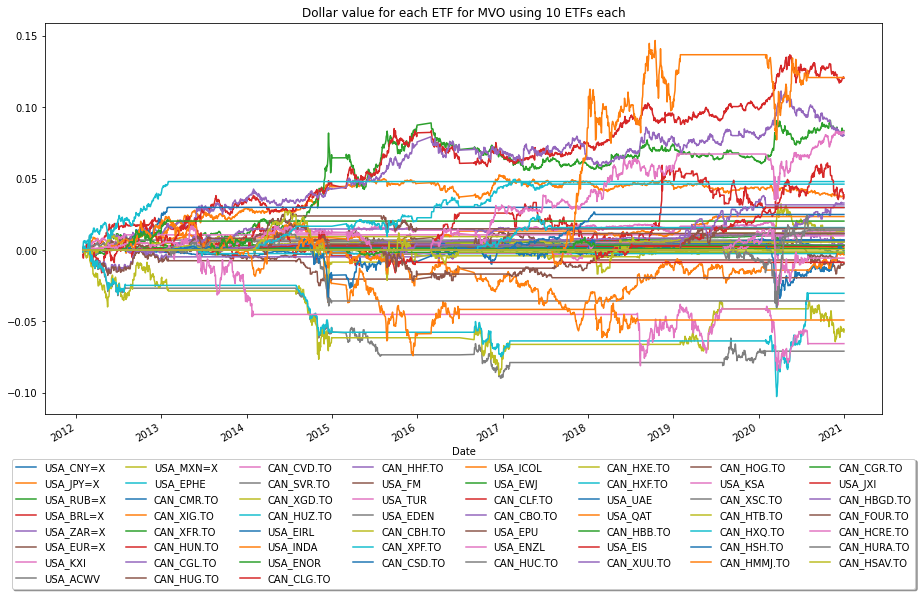

In [21]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/7))
plt.title('Dollar value for each ETF for MVO using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 10 ETFs each')

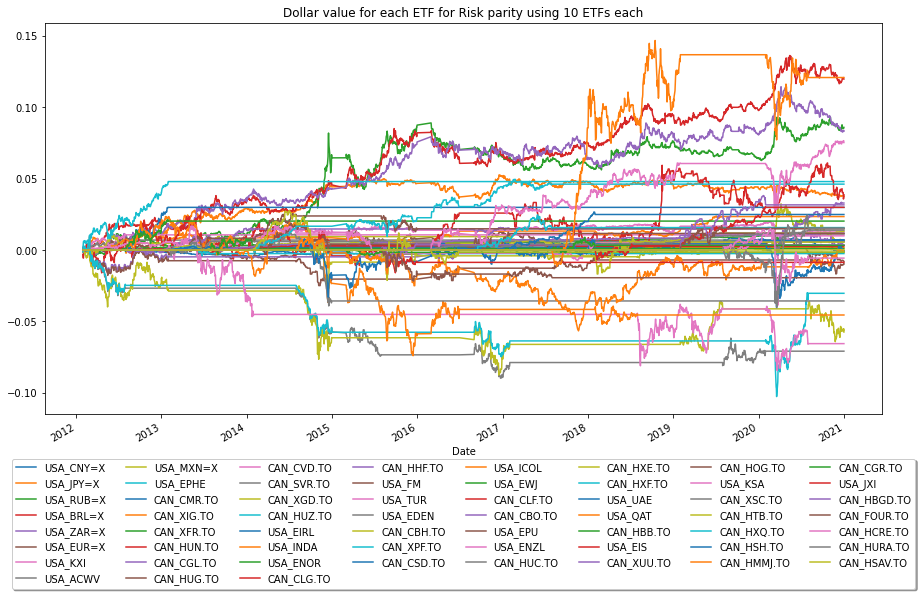

In [22]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/7))
plt.title('Dollar value for each ETF for Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 10 ETFs each')

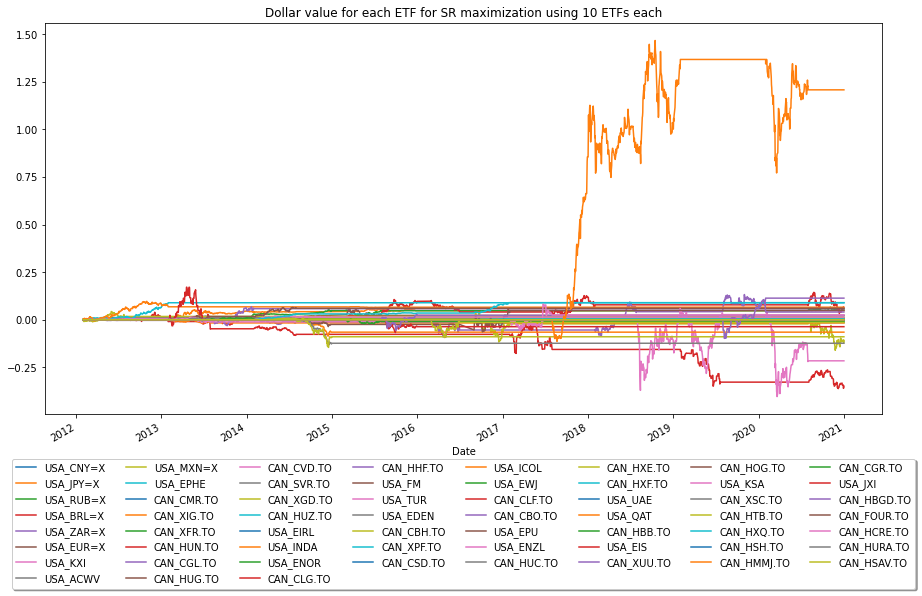

In [23]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/7))
plt.title('Dollar value for each ETF for SR maximization using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 10 ETFs each')

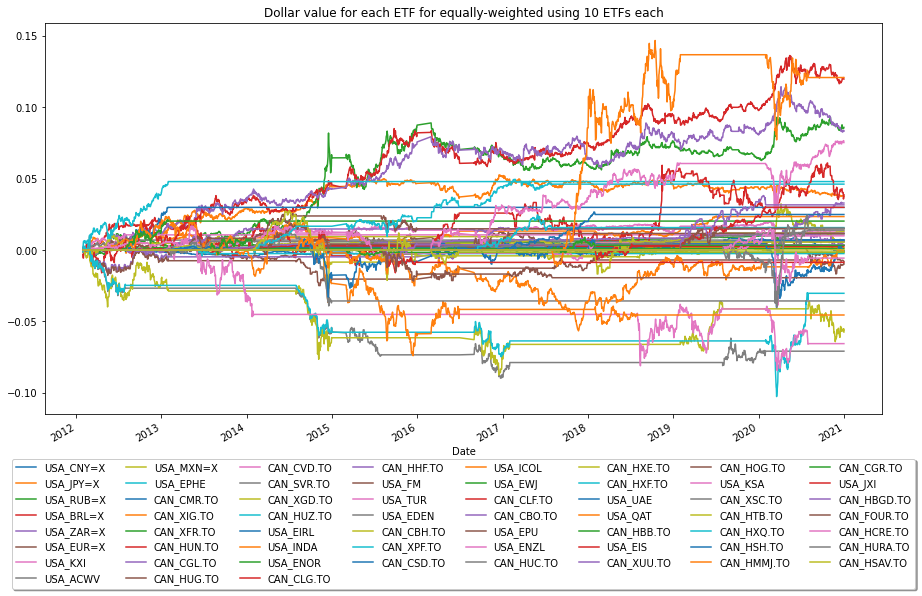

In [24]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/7))
plt.title('Dollar value for each ETF for equally-weighted using 10 ETFs each')

15 cutoff ETFs

In [25]:
opt15 = portfolio_optimizer(semiannual)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq = opt10.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Equally weighted')

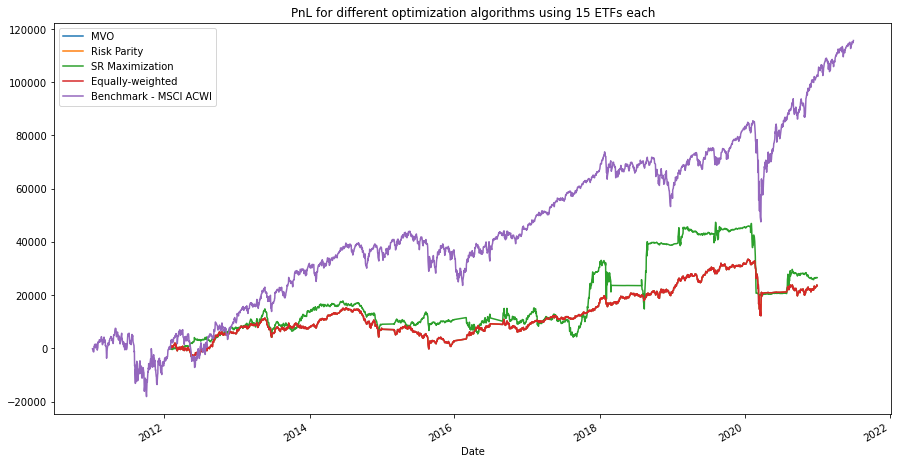

In [26]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
(benchmark_ret*100000).cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('PnL for different optimization algorithms using 15 ETFs each')
plt.legend()
plt.show()

In [27]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -253.94057762762984%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -840.446208 -1299.095699 -1097.092344 -1403.443529
3       -534.676642  -780.619421  -708.417809  -888.369888
4       -688.067576 -1522.537564 -1064.826268 -1617.942460
5       -677.956238 -1020.663254  -875.951424 -1120.320134
6       -431.155549  -515.972260  -514.582181  -671.953329
7       -962.608003 -1434.982044 -1268.421400 -1565.684710
8       -789.903564 -1141.279201 -1042.024231 -1209.129567
9      -1045.819353 -2290.774486 -1749.639289 -3330.433716
10      -794.496100 -1232.204045 -1134.899062 -1746.293604
11      -757.309918 -1452.199466 -1089.754826 -1533.917867
12      -473.444869  -619.936480  -591.320628  -726.189346
13      -442.542017  -731.477501  -601.127525  -782.513577
14      -729.382524 -1067.114284  -937.541517 -1202.042998
15      -856.755760 -1352.556537 -1140.819777 -1483.644850
16      -696.512855 -1270.860487  -987.346178 -1428.111487
17      -692.319621 -1170.262918  -898.252410 -1209.339126
18     -2397.927827 -6141.415393 -4471.100112 -6704.365272
19     -1087.646814 -1775.329571 -1454.001039 -1999.312347

In [28]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -253.93956440132516%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -840.442362 -1299.089481 -1097.087423 -1403.436653
3       -534.675504  -780.618449  -708.416701  -888.368599
4       -688.067213 -1522.537163 -1064.825879 -1617.941892
5       -677.955274 -1020.661794  -875.949992 -1120.318571
6       -431.155331  -515.971969  -514.582001  -671.953004
7       -962.606915 -1434.980687 -1268.420462 -1565.683366
8       -789.902440 -1141.276499 -1042.022335 -1209.127196
9      -1045.819263 -2290.774139 -1749.639033 -3330.433395
10      -794.494646 -1232.202382 -1134.897434 -1746.291809
11      -757.309898 -1452.196939 -1089.753552 -1533.915473
12      -473.444926  -619.936448  -591.320703  -726.189410
13      -442.541866  -731.477515  -601.127469  -782.513556
14      -729.381935 -1067.114728  -937.540912 -1202.042560
15      -856.754920 -1352.553997 -1140.818572 -1483.642952
16      -696.512176 -1270.857413  -987.344949 -1428.109253
17      -692.319447 -1170.262826  -898.252226 -1209.338913
18     -2397.928151 -6141.416862 -4471.101112 -6704.366853
19     -1087.640512 -1775.322450 -1453.994953 -1999.306709

In [29]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -270.65214042026884%


VaR 95%       VaR 99%     CVaR 95%      CVaR 99%
Period                                                      
2       -342.077788   -463.972465  -412.031579   -510.408980
3       -464.104989   -569.729037  -558.192157   -697.724946
4      -1160.343679  -1842.260578 -1518.305174  -2129.541092
5       -762.649473  -1436.804996 -1118.755064  -1576.173550
6       -500.719070   -696.810804  -607.837784   -767.393070
7       -754.592494  -1399.725948 -1079.801706  -1461.208661
8       -546.507687   -847.567710  -706.702398   -885.365505
9      -1299.853408  -2663.574159 -1931.467458  -3035.823765
10     -1236.581581  -1675.804265 -1502.735178  -1733.489597
11     -1830.304203  -2601.951455 -2352.920588  -2950.634567
12     -2269.327945  -3990.464444 -3188.203047  -4128.788096
13     -3902.208812  -7189.541718 -5894.809575  -7646.418957
14     -3633.823252  -7284.773032 -5312.569246  -7771.827175
15     -5433.656719  -9673.257634 -7705.301859 -10151.515309
16     -4158.841001  -8200.410428 -5958.621709  -9223.673710
17     -3789.574157  -6162.460355 -4888.586946  -6249.727194
18     -6027.126298 -10538.920789 -8820.962287 -12296.942414
19     -2679.589913  -4155.099108 -3777.602505  -5145.419544

In [30]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -253.94057762762984%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -840.446208 -1299.095699 -1097.092344 -1403.443529
3       -534.676642  -780.619421  -708.417809  -888.369888
4       -688.067576 -1522.537564 -1064.826268 -1617.942460
5       -677.956238 -1020.663254  -875.951424 -1120.320134
6       -431.155549  -515.972260  -514.582181  -671.953329
7       -962.608003 -1434.982044 -1268.421400 -1565.684710
8       -789.903564 -1141.279201 -1042.024231 -1209.129567
9      -1045.819353 -2290.774486 -1749.639289 -3330.433716
10      -794.496100 -1232.204045 -1134.899062 -1746.293604
11      -757.309918 -1452.199466 -1089.754826 -1533.917867
12      -473.444869  -619.936480  -591.320628  -726.189346
13      -442.542017  -731.477501  -601.127525  -782.513577
14      -729.382524 -1067.114284  -937.541517 -1202.042998
15      -856.755760 -1352.556537 -1140.819777 -1483.644850
16      -696.512855 -1270.860487  -987.346178 -1428.111487
17      -692.319621 -1170.262918  -898.252410 -1209.339126
18     -2397.927827 -6141.415393 -4471.100112 -6704.365272
19     -1087.646814 -1775.329571 -1454.001039 -1999.312347

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 15 ETFs each')

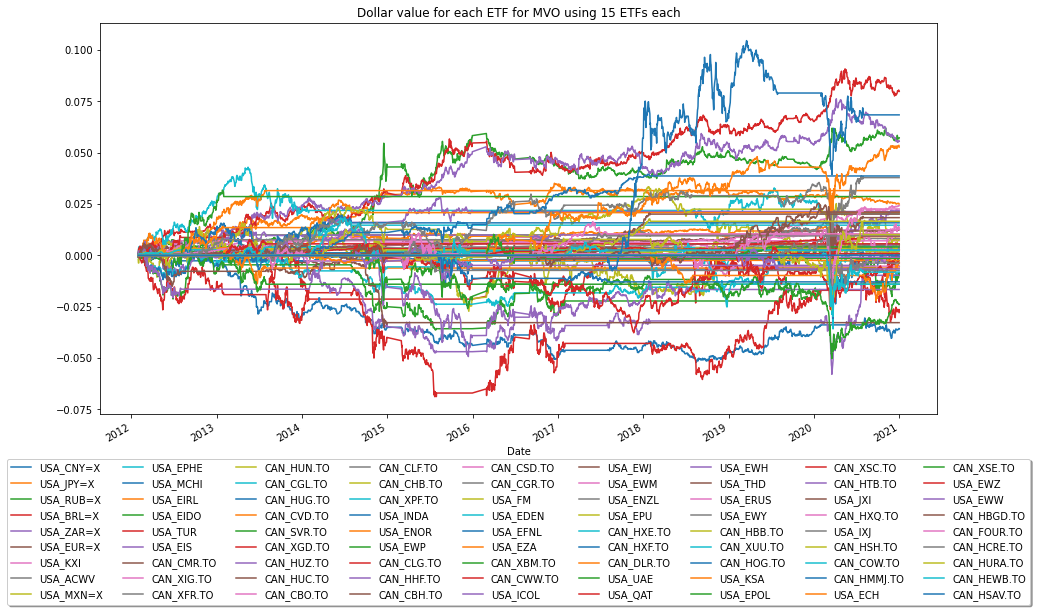

In [31]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/9))
plt.title('Dollar value for each ETF for MVO using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 15 ETFs each')

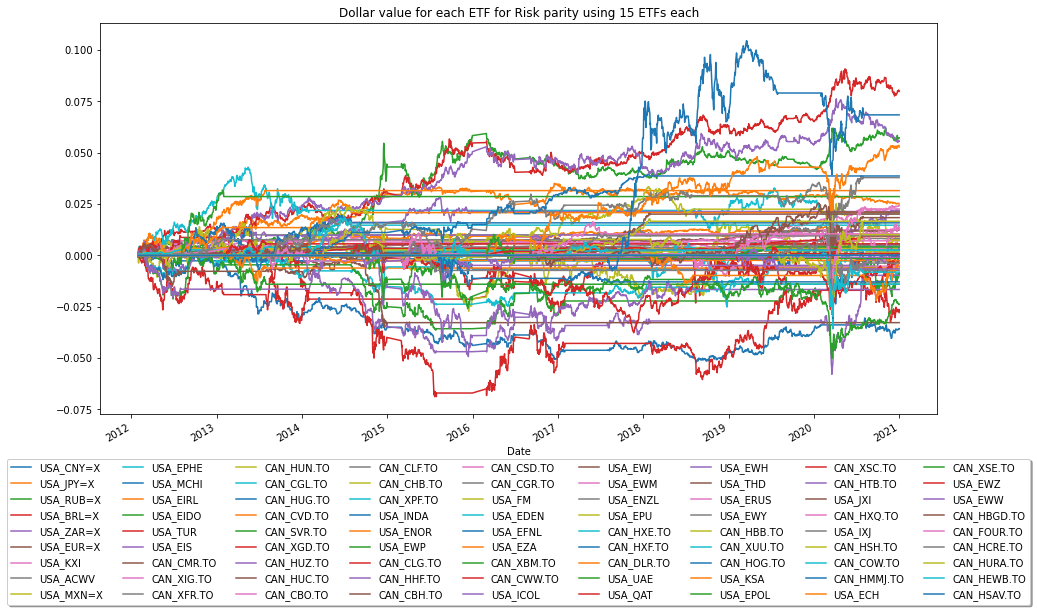

In [32]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/9))
plt.title('Dollar value for each ETF for Risk parity using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 15 ETFs each')

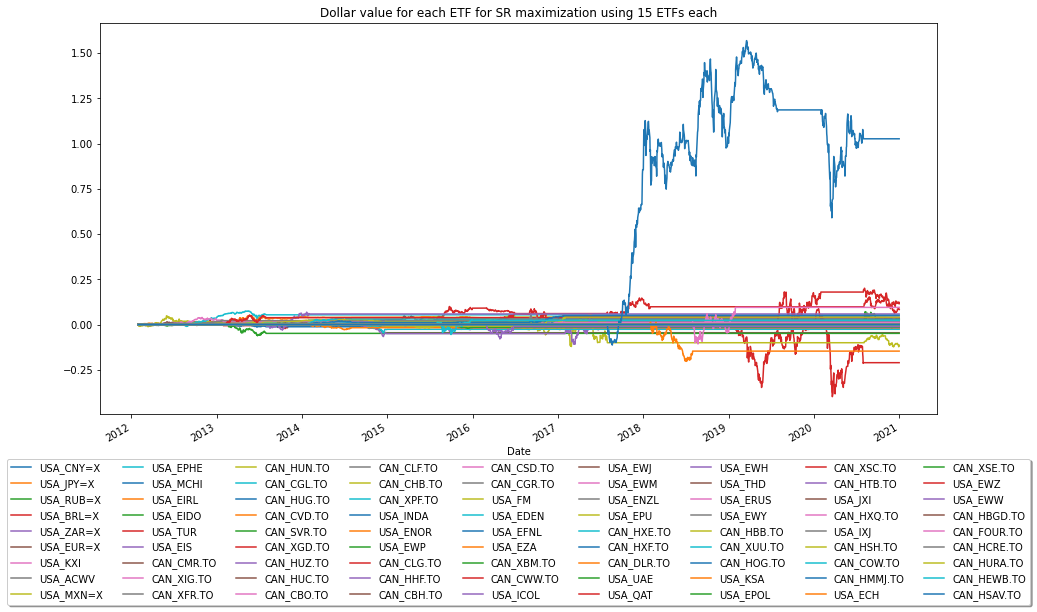

In [33]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/9))
plt.title('Dollar value for each ETF for SR maximization using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 15 ETFs each')

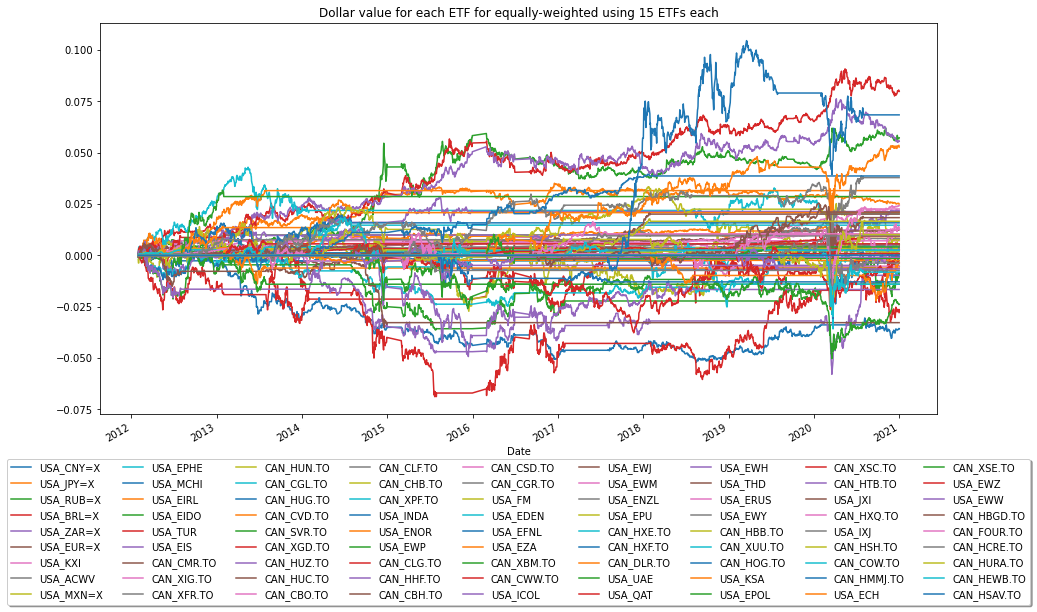

In [34]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/9))
plt.title('Dollar value for each ETF for equally-weighted using 15 ETFs each')

30 cutoff ETFs

In [35]:
opt30 = portfolio_optimizer(semiannual)

# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq = opt10.portfolio_simulator(100000, riskfree, top30, 30, VaRcutoff, 'Equally weighted')

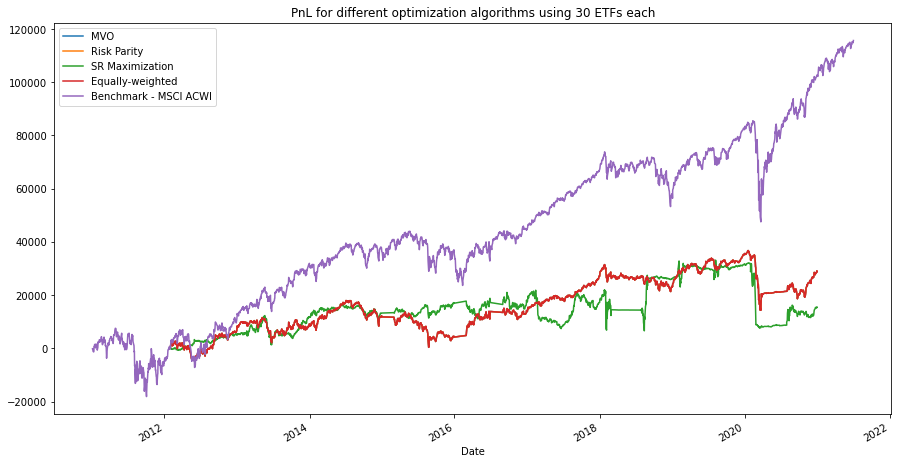

In [36]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
(benchmark_ret*100000).cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('PnL for different optimization algorithms using 30 ETFs each')
plt.legend()
plt.show()

In [37]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -268.18290274170636%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -966.905809 -1510.723675 -1245.791791 -1521.466684
3       -543.124437  -947.590881  -765.507444  -983.786751
4       -901.059987 -1951.374600 -1499.286478 -2393.540124
5      -1019.554353 -1533.862489 -1294.130602 -1662.036581
6       -690.756474 -1121.972894  -958.394119 -1158.840262
7       -925.259765 -1218.365960 -1126.509230 -1367.494365
8       -813.509151 -1192.765931 -1040.527660 -1326.628937
9      -1177.846510 -2550.149435 -1818.911876 -2764.393548
10      -950.822999 -1645.735112 -1488.985862 -2316.706185
11      -713.410083 -1551.592043 -1128.264648 -1597.722235
12      -615.439774  -794.588394  -745.538495  -922.631143
13      -501.718145  -848.397750  -737.350377  -984.781339
14     -1042.228841 -1578.116852 -1431.747543 -1845.691090
15     -1120.800190 -1474.861052 -1361.448677 -1561.375633
16      -710.571013 -1548.767877 -1027.872365 -1609.772621
17      -759.680400 -1500.195005 -1114.474438 -1610.487282
18     -3208.969921 -8675.844622 -6102.384249 -9093.055499
19     -1240.908863 -1934.166218 -1643.471856 -2242.150055

In [38]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -268.1808041803955%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -966.893567 -1510.709636 -1245.779854 -1521.451903
3       -543.122343  -947.588477  -765.505471  -983.784520
4       -901.059389 -1951.373090 -1499.285354 -2393.538069
5      -1019.551735 -1533.858977 -1294.126774 -1662.032121
6       -690.754527 -1121.971616  -958.392004 -1158.838412
7       -925.259551 -1218.365391 -1126.508299 -1367.492959
8       -813.507771 -1192.763927 -1040.526014 -1326.626863
9      -1177.846137 -2550.148006 -1818.911212 -2764.394575
10      -950.818529 -1645.729321 -1488.980566 -2316.699399
11      -713.407279 -1551.587522 -1128.260891 -1597.717643
12      -615.439965  -794.587550  -745.537989  -922.630401
13      -501.717996  -848.397436  -737.350109  -984.781081
14     -1042.227985 -1578.116749 -1431.746796 -1845.690269
15     -1120.799116 -1474.857462 -1361.446665 -1561.373053
16      -710.569166 -1548.762606 -1027.869932 -1609.768980
17      -759.680330 -1500.194163 -1114.473809 -1610.486540
18     -3208.969100 -8675.842746 -6102.382636 -9093.053740
19     -1240.893673 -1934.146321 -1643.454243 -2242.124011

In [39]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -348.782566808302%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                       
2       -326.915837   -451.347458   -393.817837   -472.157380
3       -393.747342   -522.385246   -480.348447   -589.579203
4      -1245.726924  -1794.006323  -1594.926100  -2185.700424
5       -689.863787  -1114.798796   -963.031895  -1313.470470
6       -494.356602   -643.455324   -588.434119   -704.870871
7       -555.423010  -1025.346776   -788.334404  -1140.725273
8       -521.501223   -786.108408   -664.813821   -807.823066
9       -979.409719  -1285.669314  -1235.025851  -1660.292319
10     -1038.617649  -1385.722665  -1225.669294  -1449.474230
11     -1347.680256  -1973.224353  -1770.668449  -2286.996760
12     -2678.417736  -4211.512476  -3487.183565  -4221.735625
13     -2596.221326  -3880.130069  -3280.757705  -3898.981346
14     -4493.398886  -8501.670539  -6133.967946  -8660.233020
15     -6019.240113  -9584.144451  -7791.637325  -9998.441125
16     -3895.128470  -4960.364848  -4595.699734  -5396.729920
17     -3589.715612  -5837.457950  -4630.767478  -5920.122546
18     -7726.139588 -14825.757444 -12449.337303 -17646.951723
19     -2324.573916  -3811.757142  -3242.988676  -4473.170844

In [40]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -268.18290274170636%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -966.905809 -1510.723675 -1245.791791 -1521.466684
3       -543.124437  -947.590881  -765.507444  -983.786751
4       -901.059987 -1951.374600 -1499.286478 -2393.540124
5      -1019.554353 -1533.862489 -1294.130602 -1662.036581
6       -690.756474 -1121.972894  -958.394119 -1158.840262
7       -925.259765 -1218.365960 -1126.509230 -1367.494365
8       -813.509151 -1192.765931 -1040.527660 -1326.628937
9      -1177.846510 -2550.149435 -1818.911876 -2764.393548
10      -950.822999 -1645.735112 -1488.985862 -2316.706185
11      -713.410083 -1551.592043 -1128.264648 -1597.722235
12      -615.439774  -794.588394  -745.538495  -922.631143
13      -501.718145  -848.397750  -737.350377  -984.781339
14     -1042.228841 -1578.116852 -1431.747543 -1845.691090
15     -1120.800190 -1474.861052 -1361.448677 -1561.375633
16      -710.571013 -1548.767877 -1027.872365 -1609.772621
17      -759.680400 -1500.195005 -1114.474438 -1610.487282
18     -3208.969921 -8675.844622 -6102.384249 -9093.055499
19     -1240.908863 -1934.166218 -1643.471856 -2242.150055

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 30 ETFs each')

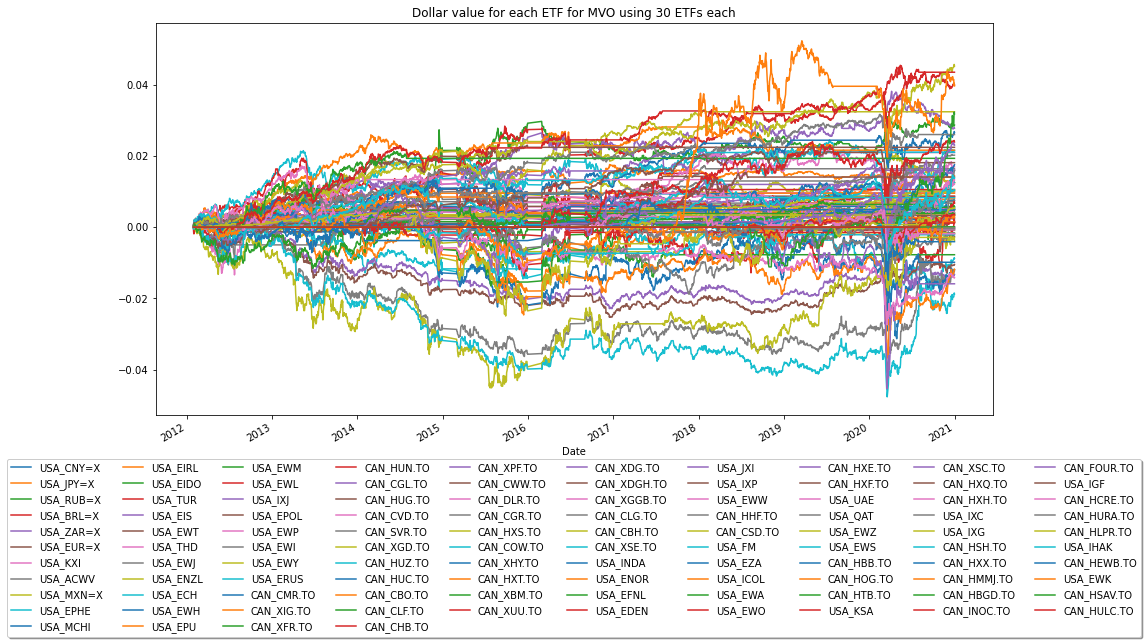

In [41]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/10))
plt.title('Dollar value for each ETF for MVO using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 30 ETFs each')

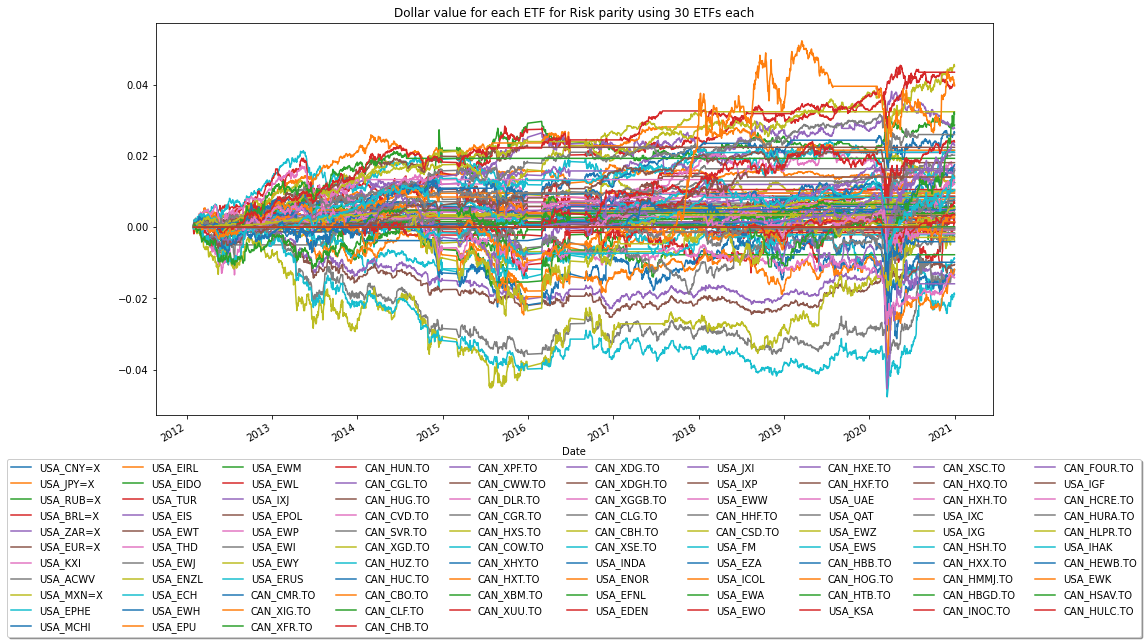

In [42]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/10))
plt.title('Dollar value for each ETF for Risk parity using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 30 ETFs each')

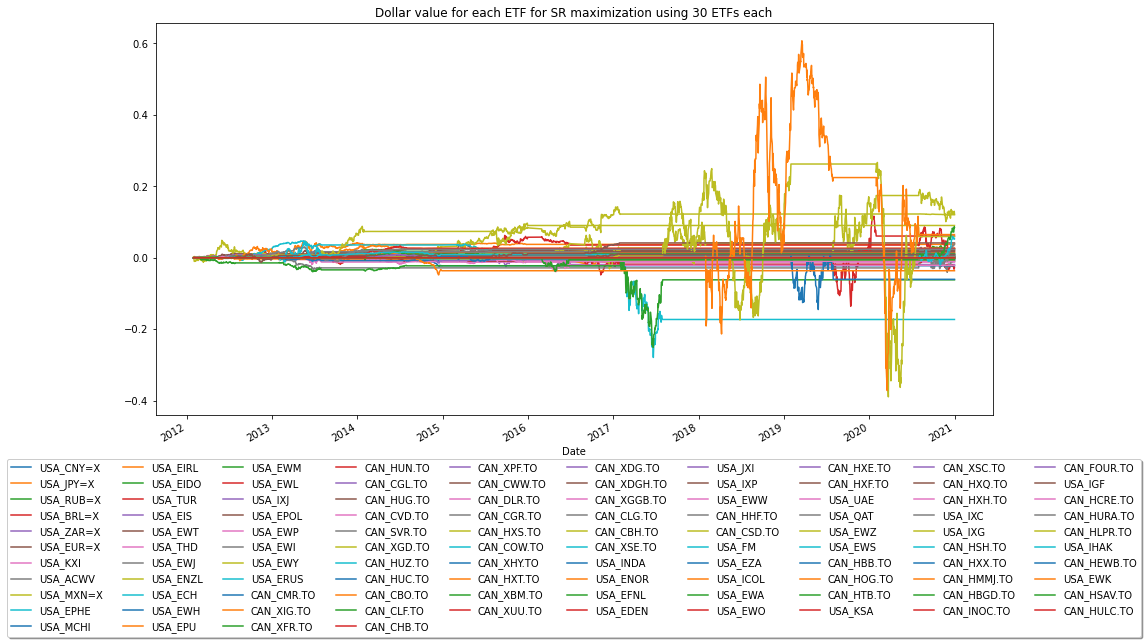

In [43]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/10))
plt.title('Dollar value for each ETF for SR maximization using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 30 ETFs each')

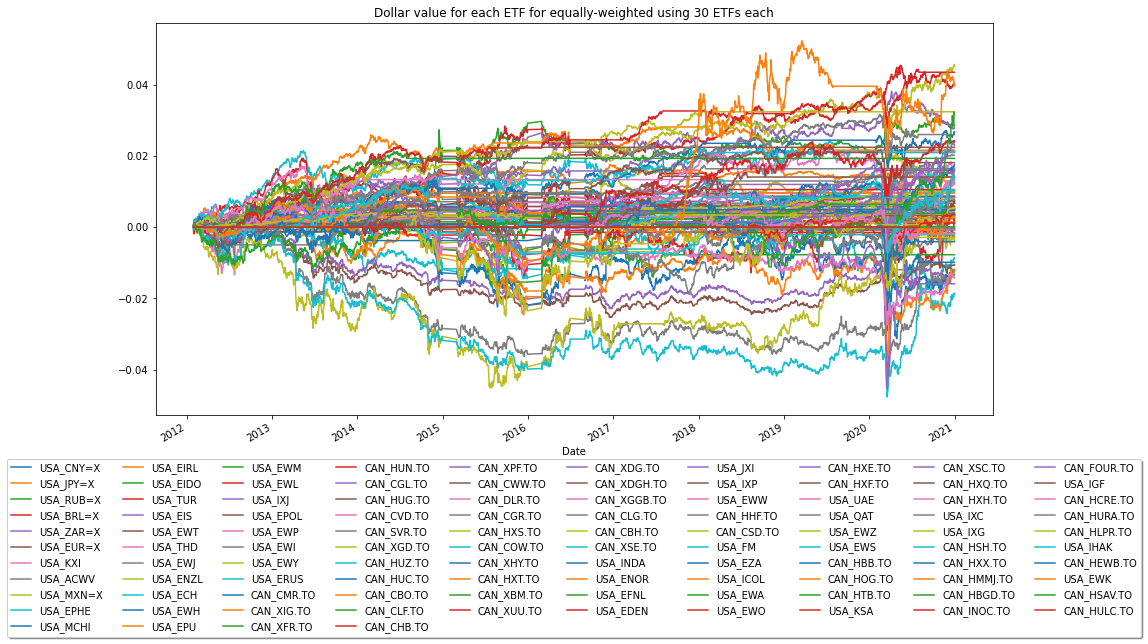

In [44]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/10))
plt.title('Dollar value for each ETF for equally-weighted using 30 ETFs each')

# Scenario Analysis

We will pick time period 2012 January to 2017 December as the scenario testing period, two scenarios will be tested:
1. the entire market will crash by 0.5% with probability 2% in a single day;
2. each ETFs will randomly crash by a half with probability 5% in a single day.

In [45]:
# extract rets from 2020.1 to 2017.12
periodic_rets = {}
for i in range(1,14):
    periodic_rets[i] = semiannual[i]

In [46]:
# Market crush scenario
opt_sa1 = portfolio_optimizer(periodic_rets)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity', scenario='Market crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='Market crash')


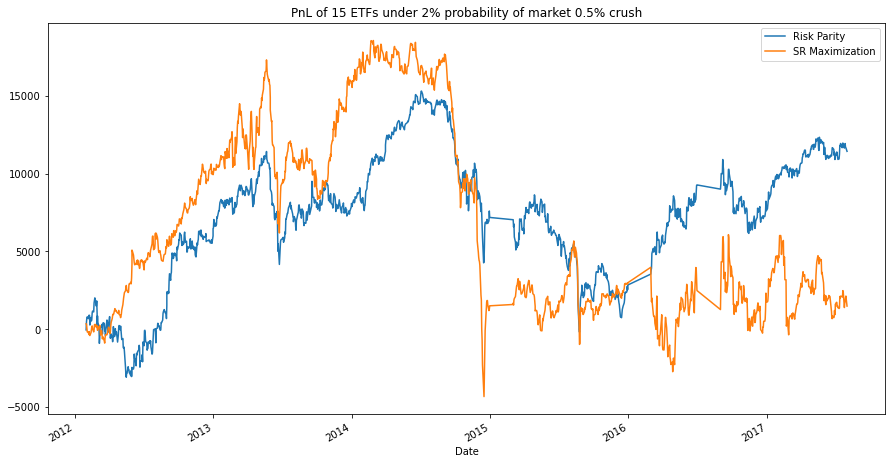

In [47]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 2% probability of market 0.5% crush')
plt.legend()
plt.show()

In [48]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -253.9395653062345%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -840.442406 -1299.089552 -1097.087478 -1403.436726
3       -534.675513  -780.618444  -708.416701  -888.368595
4       -688.067204 -1522.537150 -1064.825870 -1617.941878
5       -677.955269 -1020.661792  -875.949985 -1120.318559
6       -431.155329  -515.971968  -514.582000  -671.953006
7       -962.606901 -1434.980668 -1268.420450 -1565.683347
8       -789.902487 -1141.276576 -1042.022385 -1209.127251
9      -1045.819276 -2290.774168 -1749.638998 -3330.433233
10      -794.494684 -1232.202460 -1134.897476 -1746.291902
11      -757.309909 -1452.196965 -1089.753564 -1533.915501
12      -473.444917  -619.936431  -591.320693  -726.189390

In [49]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -364.8459808021153%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -465.395422  -727.715807  -645.002296  -887.700733
3       -513.161979  -612.945928  -614.143898  -769.694164
4      -1517.264796 -2242.192546 -1968.905567 -2706.790223
5       -794.668442 -1549.908301 -1190.777419 -1681.807793
6       -647.664746  -843.629376  -756.860464  -957.849110
7      -1195.727283 -2379.264835 -1870.994302 -2522.864733
8       -567.231596  -893.564178  -725.039444  -928.498663
9      -1395.088405 -2660.893719 -1990.179679 -3034.404971
10     -1271.095832 -1725.329334 -1556.511314 -1808.712399
11     -1847.881907 -2568.226278 -2340.140583 -2948.646119
12     -2114.773388 -3718.690386 -2971.067700 -3847.593385

In [50]:
# Individual ETF random crush scenario
opt_sa2 = portfolio_optimizer(periodic_rets)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt_sa2.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity', scenario='Random ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt_sa2.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='Random ETF crash')


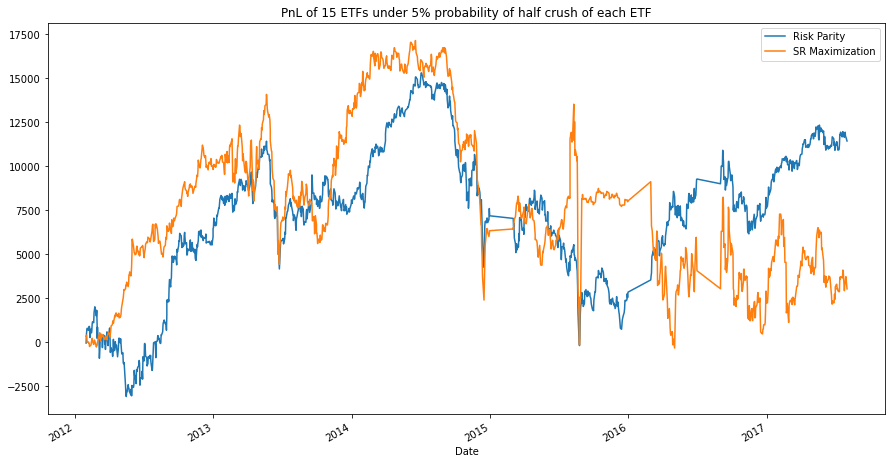

In [51]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of half crush of each ETF')
plt.legend()
plt.show()

In [52]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -253.9394911695616%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -840.442191 -1299.089116 -1097.087182 -1403.436274
3       -534.675424  -780.618404  -708.416636  -888.368530
4       -688.067219 -1522.537185 -1064.825892 -1617.941914
5       -677.955251 -1020.661761  -875.949965 -1120.318555
6       -431.155312  -515.971948  -514.581987  -671.952982
7       -962.606898 -1434.980658 -1268.420451 -1565.683349
8       -789.902433 -1141.276541 -1042.022345 -1209.127219
9      -1045.819209 -2290.774036 -1749.639040 -3330.433544
10      -794.494637 -1232.202384 -1134.897419 -1746.291778
11      -757.309920 -1452.196924 -1089.753539 -1533.915456
12      -473.444910  -619.936395  -591.320661  -726.189330

In [53]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -169.85112908831675%


VaR 95%      VaR 99%     CVaR 95%     CVaR 99%
Period                                                    
2       -349.461244  -613.028486  -518.057845  -727.522500
3       -571.485392  -724.934370  -667.964825  -803.057333
4      -1564.471749 -2586.132134 -1981.710772 -2727.206934
5       -778.260602 -1545.141653 -1171.787561 -1686.598074
6       -511.019888  -730.725514  -639.968979  -809.247437
7       -839.610344 -1725.164355 -1276.889249 -1775.021794
8       -596.026762  -928.434940  -758.104995  -940.808776
9      -2957.558673 -4687.220175 -3895.963124 -5041.954478
10     -1311.176072 -1688.861596 -1563.671005 -1946.175269
11     -1684.987128 -3117.863342 -2404.450435 -3349.757755
12     -2041.321789 -3589.530563 -2867.874766 -3713.956426